# Predictive Model for Heart Attacks


## Importing

In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Accessing CSV dataset

In [2]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Plotting all values on Pairplot

Identifying if there is any easily noticeable correlations between data

In [3]:
# fig, ax = plt.subplots()
# fig = (6, 24)
# sns.pairplot(data = test, hue = 'output')

## Splitting the data

 Splitting 80-10-10 for training data, validation data, and testing data

In [4]:
train, val, test = np.split(data.sample(frac=1), [int(0.8*len(data)), int(0.9*len(data))])

In [5]:
print(len(train))
print(len(val))
print(len(test))

242
30
31


## DataFrame to TensorFlow Dataset Function

Creating a function that converts dataframes to TensorFlow datasets so that we can use TensorFlow operations on it

In [6]:
def df_to_dataset(data, shuffle=True, batch_size = 32):
  df = data.copy()
  labels = df.pop('output')
  df = {key:value[:, tf.newaxis] for key, value in data.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df),labels))
  if shuffle:
    ds = ds.shuffle(buffer_size = len(data))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

## Normalization Function

Since all features are numerical, we use a normalization layer function to normalize each feature

In [7]:
def get_normalization_layer(name, dataset):
  normalizer = tf.keras.layers.Normalization(axis = None)
  feature_ds = dataset.map(lambda x, y:x[name])
  normalizer.adapt(feature_ds)
  return normalizer

## Processing data

We use both the functions to process our data for modeling

In [8]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

<ipython-input-6-e39511b8e735>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:, tf.newaxis] for key, value in data.items()}
<ipython-input-6-e39511b8e735>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key:value[:, tf.newaxis] for key, value in data.items()}


In [9]:
all_inputs = []
encoded_features = []

for header in [
    'age',
    'sex',
    'cp',
    'trtbps',
    'chol',
    'fbs',
    'restecg',
    'thalachh',
    'exng',
    'oldpeak',
    'slp',
    'caa',
    'thall']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

## Modeling

Modeling with TensorFlow layers

In [10]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

### Compiling the Model

Compiling the model with the optimizer Adam, a loss function for Binary Crossentropy, and results with a metrics of accuracy

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

### Visualization for the model operations

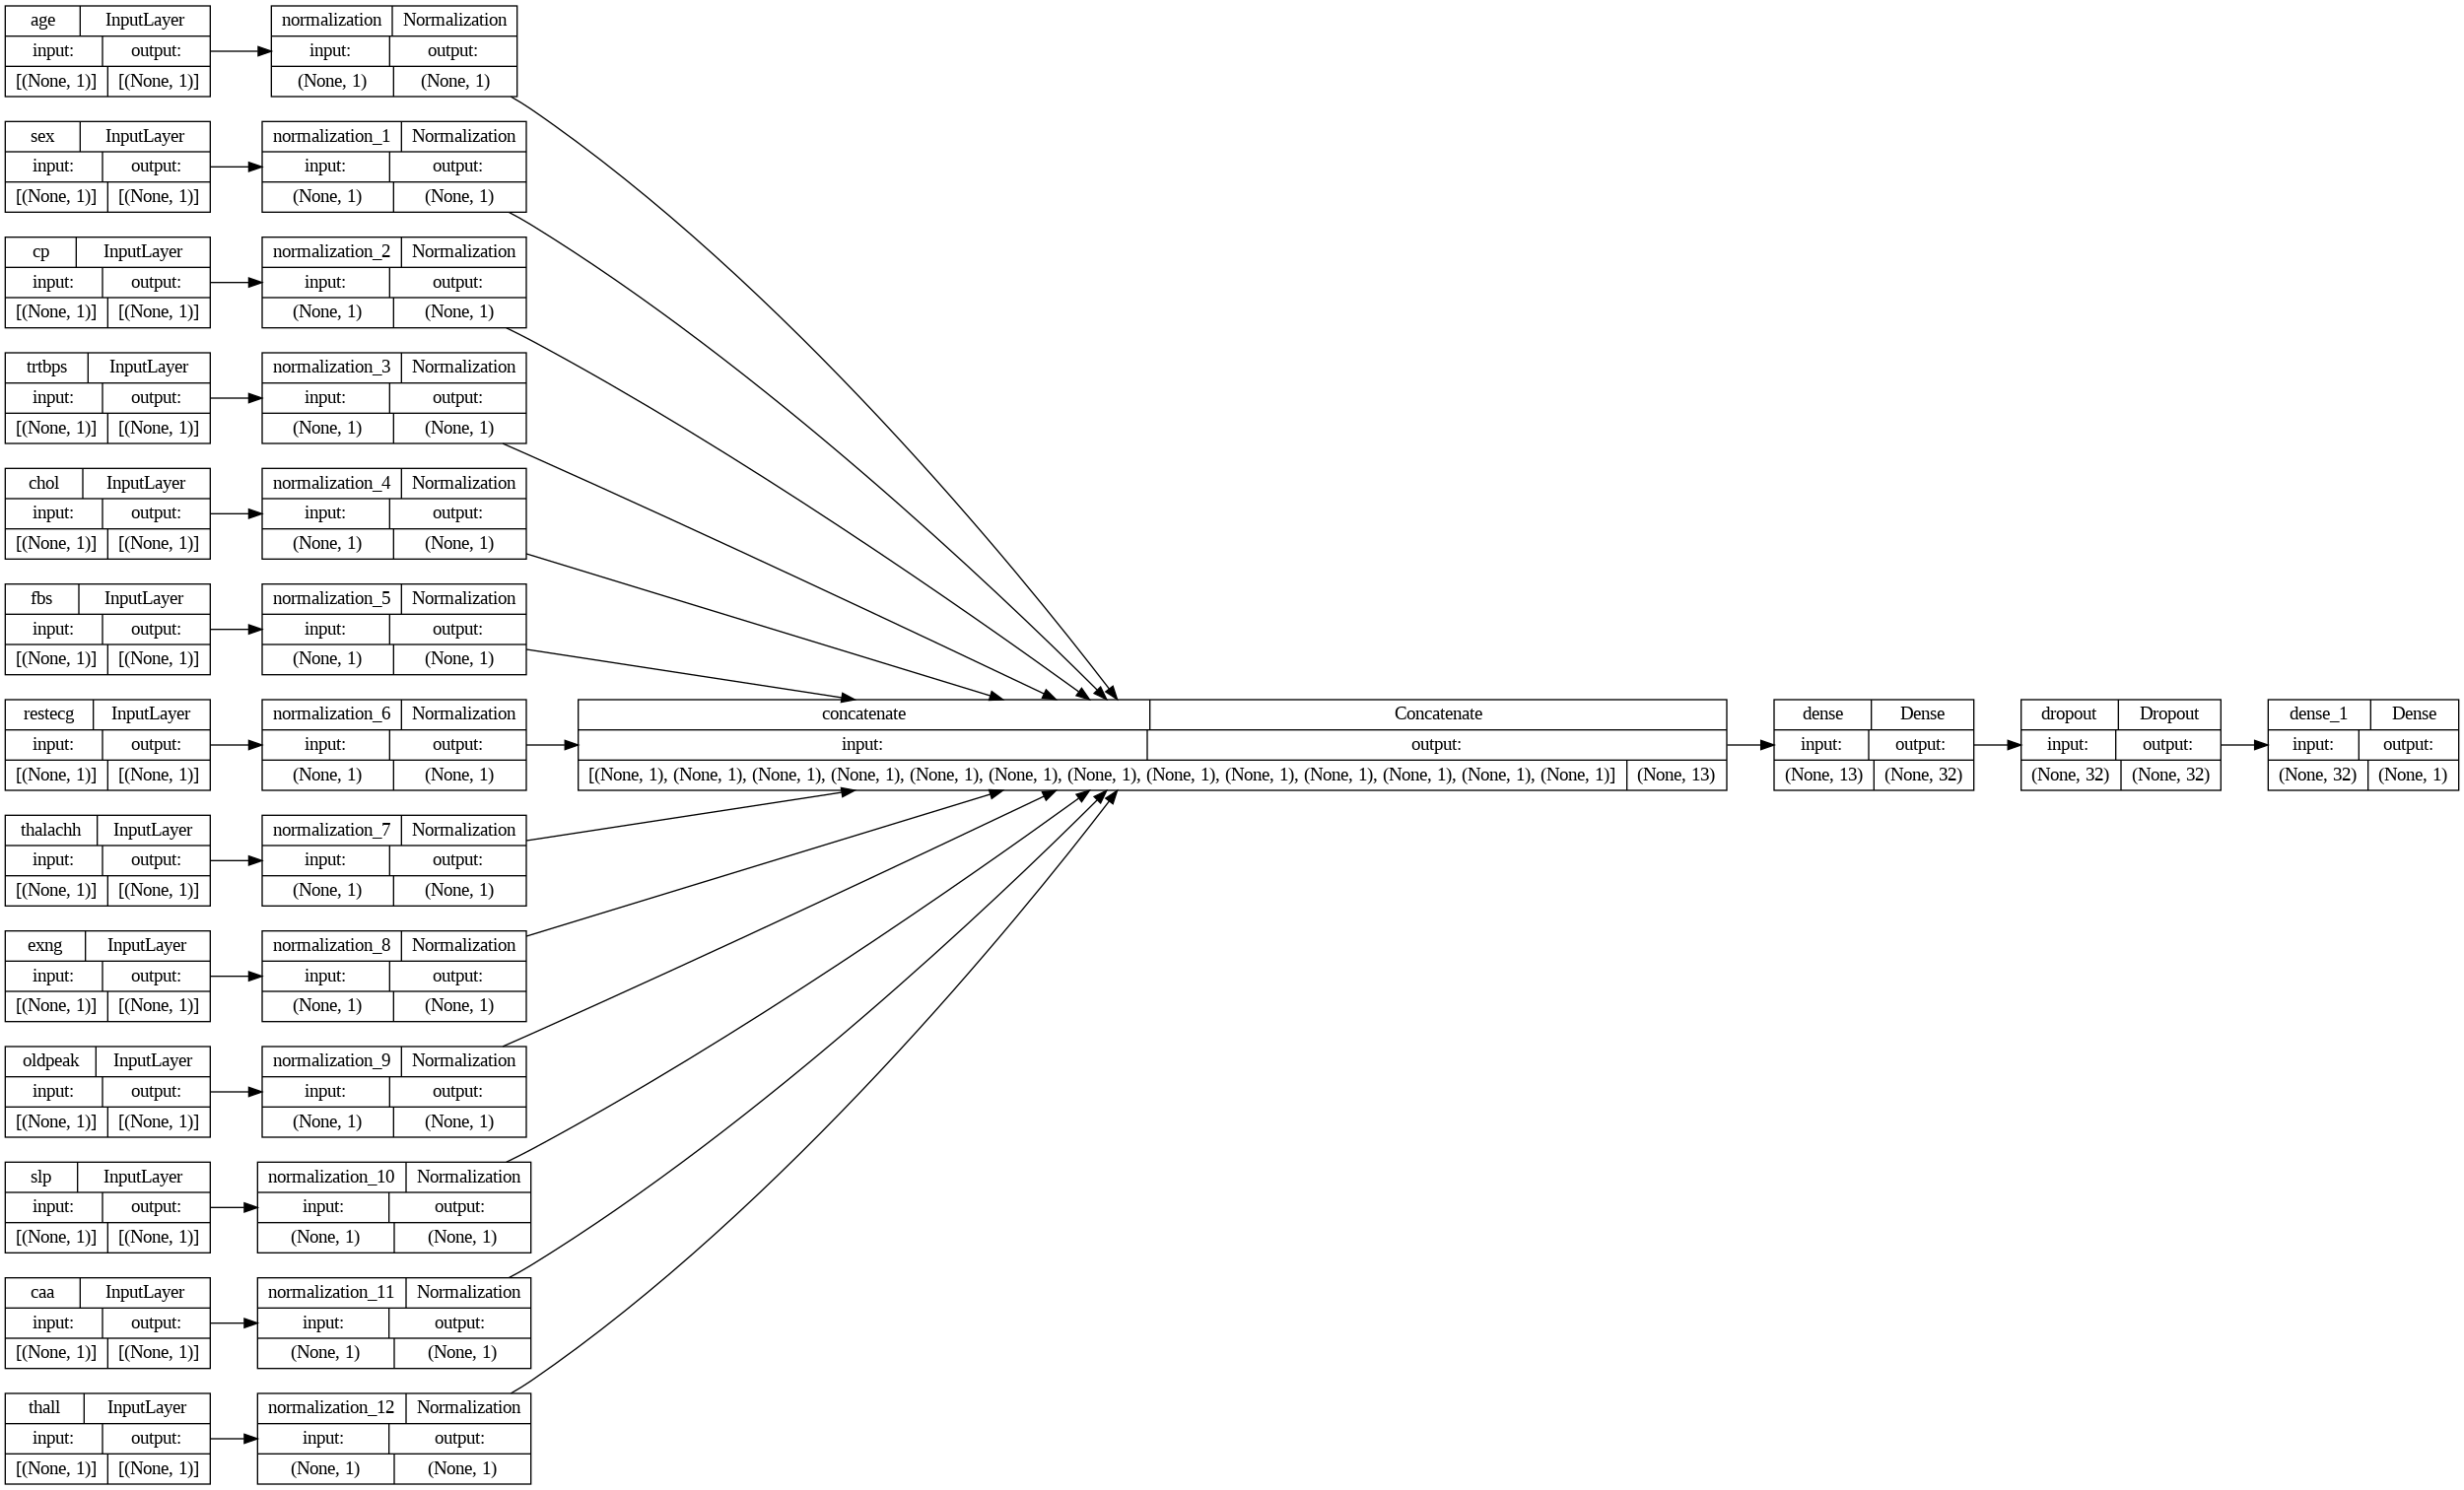

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Fitting the Model

Fitting the model over 1000 iterations against the validation data

In [13]:
model.fit(train_ds, epochs=1000, validation_data=val_ds)

Epoch 1/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['output'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


1/1 [==============================] - 3s 3s/step - loss: 0.9857 - accuracy: 0.3512 - val_loss: 0.8659 - val_accuracy: 0.5000
Epoch 2/1000
1/1 [==============================] - 0s 163ms/step - loss: 0.9462 - accuracy: 0.4050 - val_loss: 0.8570 - val_accuracy: 0.5000
Epoch 3/1000
1/1 [==============================] - 0s 153ms/step - loss: 0.9801 - accuracy: 0.3926 - val_loss: 0.8479 - val_accuracy: 0.5000
Epoch 4/1000
1/1 [==============================] - 0s 101ms/step - loss: 1.0125 - accuracy: 0.3347 - val_loss: 0.8392 - val_accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 91ms/step - loss: 1.0063 - accuracy: 0.3678 - val_loss: 0.8304 - val_accuracy: 0.5000
Epoch 6/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.9580 - accuracy: 0.3760 - val_loss: 0.8218 - val_accuracy: 0.5000
Epoch 7/1000
1/1 [==============================] - 0s 157ms/step - loss: 0.9640 - accuracy: 0.3926 - val_loss: 0.8135 - val_accuracy: 0.5667
Epoch 8/1000
1/1 [======

### Evaluating the Model

In [14]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)

1/1 [==============================] - 0s 40ms/step - loss: 0.3504 - accuracy: 0.9032
Accuracy 0.9032257795333862
Loss 0.35039621591567993


### Saving the Model

In [15]:
model.save('heartattackpred.keras')

## Testing

If testing an already existing model, start from here

In [ ]:
import tensorflow as tf
import pandas as pd

### Loading the Model

In [16]:
reloaded_model = tf.keras.models.load_model('heartattackpred.keras')

### Testing the Model

Using a sigmoid function on the model to create a probabilty that a patient may have a heart attack

Creating a new dataframe that can hold the new probabilty and test output

In [17]:
results = []
for i, patient in test.iterrows():
  sample = dict(patient)


  input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
  predictions = reloaded_model.predict(input_dict)
  prob = tf.nn.sigmoid(predictions[0])

  patient['probability'] = round(float(prob*100))
  results.append(patient)
  i+=1

results = pd.DataFrame(results)


1/1 [==============================] - 0s 33ms/step


Comparing the probabilty results to the actual output

In [18]:
print(results[['probability', 'output']])

     probability  output
206          6.0     0.0
299         75.0     0.0
54         100.0     1.0
236          8.0     0.0
147        100.0     1.0
205         28.0     0.0
270         36.0     0.0
156         98.0     1.0
6           97.0     1.0
17          85.0     1.0
35          95.0     1.0
12          94.0     1.0
177         88.0     0.0
219         15.0     0.0
151         81.0     1.0
196         55.0     0.0
241         46.0     0.0
187          1.0     0.0
120         10.0     1.0
94          99.0     1.0
226         21.0     0.0
64          97.0     1.0
108         99.0     1.0
98          77.0     1.0
84          89.0     1.0
275         16.0     0.0
207          1.0     0.0
65         100.0     1.0
239         62.0     0.0
179         11.0     0.0
68          97.0     1.0
